In [64]:
# importing the necessary libraries

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
df = pd.read_csv("coinmarketcap datasets/bitcoin_data.csv")

In [65]:
df.head()

,Date,Open*,High,Low,Close**,Volume,Market Cap
0,"Oct 24, 2021","61,368.34","61,505.80","59,643.35","60,930.84","27,316,183,882","1,148,743,134,468"
1,"Oct 23, 2021","60,694.63","61,743.88","59,826.52","61,393.62","26,882,546,034","1,157,410,091,263"
2,"Oct 22, 2021","62,237.89","63,715.02","60,122.80","60,692.26","38,434,082,775","1,144,131,483,274"
3,"Oct 21, 2021","66,002.23","66,600.55","62,117.41","62,210.17","45,908,121,370","1,172,684,282,558"
4,"Oct 20, 2021","64,284.59","66,930.39","63,610.67","65,992.84","40,788,955,582","1,243,927,428,207"


In [66]:
# taking one year of data for training

df['dates'] = df['Date'].apply(pd.to_datetime)
df['Open*'] = df['Open*'].str.replace(',', '').astype(float)
df['Close**'] = df['Close**'].str.replace(',', '').astype(float)
df['output_y'] = np.log(df['Close**']) - np.log(df['Open*'])
df_train = df.iloc[365:29:-1]

<AxesSubplot:xlabel='dates'>

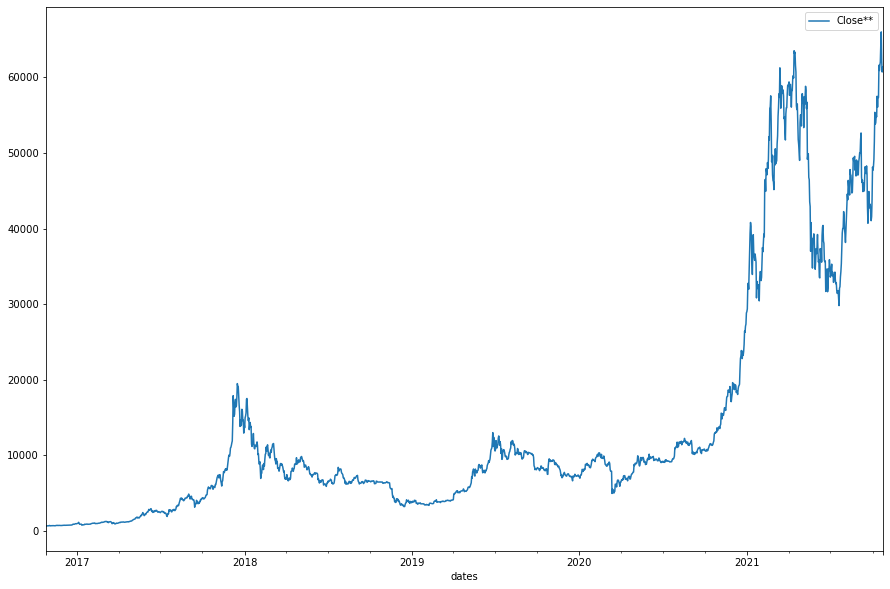

In [67]:
# plotting the close values

df.plot(x = 'dates', y = 'Close**', figsize=(15,10))

In [68]:
# converting into the 'ds', 'y' format as required by fbprophet

df = df[['dates','Close**']]
df_train = df_train[['dates','Close**']]

df.columns = ['ds','y']
df_train.columns = ['ds','y']

df['ds'] = pd.to_datetime(df['ds'])
df_train['ds'] = pd.to_datetime(df_train['ds'])

<ipython-input-68-025e83eee21e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ds'] = pd.to_datetime(df['ds'])


In [69]:
# fitting the training data on the model

model=Prophet(seasonality_mode="additive")
model.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [70]:
# making the forecast

future_dates = model.make_future_dataframe(periods=30, include_history=False)
prediction = model.predict(future_dates)
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-09-25,50445.873350,45712.330113,55584.372202,50445.873350,50445.873350,256.249422,256.249422,256.249422,256.249422,256.249422,256.249422,0.0,0.0,0.0,50702.122772
1,2021-09-26,50647.355807,45747.621010,55503.999703,50647.355807,50647.355807,138.676597,138.676597,138.676597,138.676597,138.676597,138.676597,0.0,0.0,0.0,50786.032404
2,2021-09-27,50848.838263,45459.876599,55807.942937,50848.838263,50848.838263,-51.812455,-51.812455,-51.812455,-51.812455,-51.812455,-51.812455,0.0,0.0,0.0,50797.025808
3,2021-09-28,51050.320720,45608.866931,55836.130385,51047.962746,51064.080487,-243.122020,-243.122020,-243.122020,-243.122020,-243.122020,-243.122020,0.0,0.0,0.0,50807.198700
4,2021-09-29,51251.803176,46120.480394,55932.117346,51233.838127,51295.637821,-56.888309,-56.888309,-56.888309,-56.888309,-56.888309,-56.888309,0.0,0.0,0.0,51194.914867


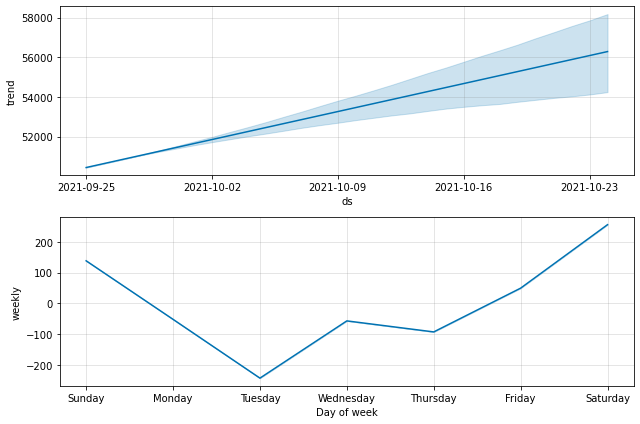

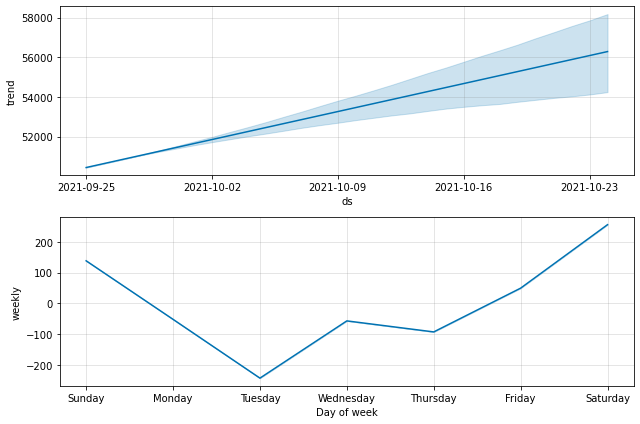

In [71]:
# plotting the model components

model.plot_components(prediction)

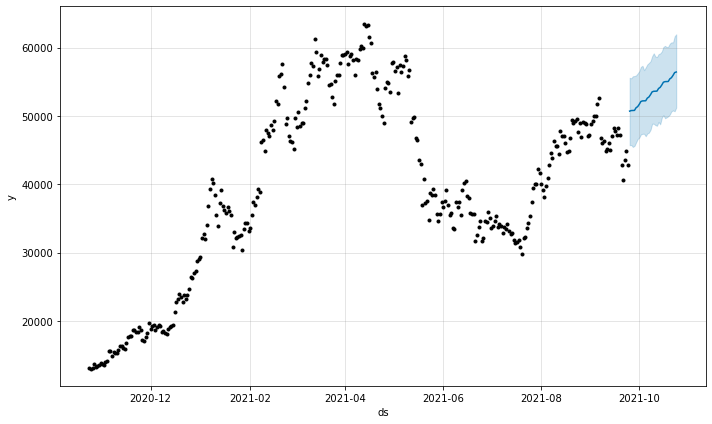

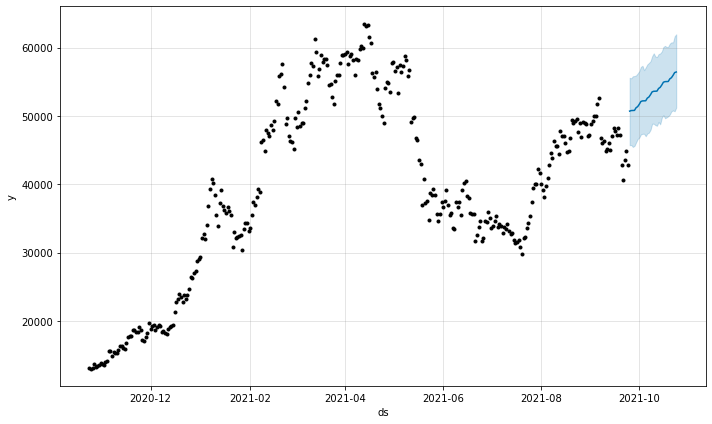

In [72]:
# plotting the prediction

model.plot(prediction)

In [73]:
actual = df[(df['ds'] > '2021-09-24') & (df['ds'] < '2021-10-24')]['y'][::-1]

forecast_period_dates = pd.date_range(start='24/09/2021', end='24/10/2021', freq='1D')
forecast_period_dates = pd.DataFrame(forecast_period_dates)
forecast_period_dates.columns = ['ds']

prediction = model.predict(forecast_period_dates)
prediction_actual = prediction['yhat']
prediction_low = prediction['yhat_lower']
prediction_high = prediction['yhat_upper']

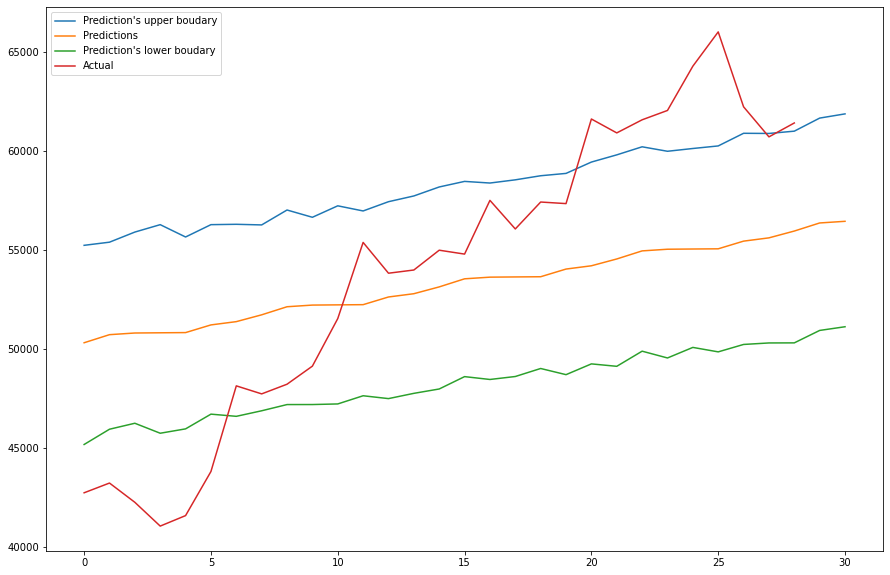

In [74]:
# plotting predictions for the last one month(oct 2021)

%matplotlib inline
fig, ax = plt.subplots(figsize=(15,10)) 

plt.plot(np.array(prediction_high), label="Prediction's upper boudary")

plt.plot(np.array(prediction_actual), label='Predictions')

plt.plot(np.array(prediction_low), label="Prediction's lower boudary")

plt.plot(np.array(actual), label='Actual')

plt.legend()

In [79]:
# The initial model will be trained on the first 300 days of data. It will forecast 
# the next 7 days of data (because horizon is set to 7). The model will then train on the initial period + 
# the period (300 + 5 days in this case) and forecast the next 7 days. It will continue like this, adding 
# another 5 days to the training data and then forecasting for the next 7 until there is no longer enough
# data to do this.

df_cv_results = cross_validation(model, initial='300 days', period='5 days', horizon = '7 days') 
df_cv_results

INFO:fbprophet:Making 6 forecasts with cutoffs between 2021-08-23 00:00:00 and 2021-09-17 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-08-24,43349.825358,38508.956623,48387.065663,47706.12,2021-08-23
1,2021-08-25,43587.804814,38792.226578,48409.883764,48960.79,2021-08-23
2,2021-08-26,43736.490267,38805.340252,48645.963702,46942.22,2021-08-23
3,2021-08-27,44103.178700,39372.922543,48978.733979,49058.67,2021-08-23
4,2021-08-28,44284.576522,39681.538078,49240.808127,48902.40,2021-08-23
5,2021-08-29,44291.501698,39260.220793,48689.706673,48829.83,2021-08-23
6,2021-08-30,44404.418325,39792.519835,49360.786384,47054.98,2021-08-23
7,2021-08-29,46494.471838,42080.475290,51029.742961,48829.83,2021-08-28
8,2021-08-30,46658.907560,42017.542095,51283.438360,47054.98,2021-08-28
9,2021-08-31,46809.689970,42119.515795,51526.444744,47166.69,2021-08-28


In [80]:
# displaying the performance metrics table

df_perf_metrics = performance_metrics(df_cv_results)
df_perf_metrics

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,1.395632e+07,3735.815577,3461.003284,0.073699,0.072899,0.833333
1,2 days,1.256593e+07,3544.845877,3079.861191,0.064598,0.079072,0.833333
2,3 days,2.277844e+07,4772.676371,3971.486965,0.087305,0.065099,0.666667
3,4 days,3.434410e+07,5860.384070,5075.130365,0.112310,0.087921,0.500000
4,5 days,2.474227e+07,4974.159957,4510.075193,0.097646,0.095381,0.500000
5,6 days,2.415160e+07,4914.427949,4614.149042,0.099184,0.085871,0.500000
6,7 days,2.679974e+07,5176.846188,4489.275381,0.098516,0.080294,0.666667


/Users/siddheshshaji/opt/anaconda3/lib/python3.8/site-packages/fbprophet/plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/Users/siddheshshaji/opt/anaconda3/lib/python3.8/site-packages/fbprophet/plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


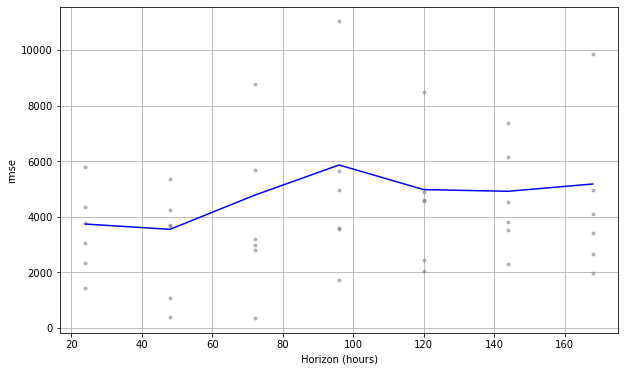

In [81]:
# plotting rmse

fig = plot_cross_validation_metric(df_cv_results, metric='rmse')